In [19]:
# Import Library 

import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Functions Library

# Evaluating function using values from Coefficient array (Setting)
def eval_poly(x, coeffs):
    # coeffs[k] multiplies x^k
    powers = np.vstack([x**k for k in range(len(coeffs))])  # shape (K, N)
    return (coeffs[:, None] * powers).sum(axis=0)

# Formatting + Threshholding Condition
def format_poly(coeffs, var="x", thresh=1e-10):
    terms = []
    for k, c in enumerate(coeffs):
        if abs(c) < thresh:
            continue
        if k == 0:
            terms.append(f"{c:+.5g}")
        elif k == 1:
            terms.append(f"{c:+.5g}·{var}")
        else:
            terms.append(f"{c:+.5g}·{var}^{k}")
    return " ".join(terms) if terms else "0"
    

In [21]:
# Setting for the model

N = 200                    # number of samples
X_MIN, X_MAX = -1.0, 1.0   # sampling range for x
DEGREE = 10                # full polynomial library up to power DEGREE
NOISE_FRAC = 0.05          # noise level as fraction of std(y_true)
TRUE_COEFFS = np.array([3.0, 0.0, -3.0, 0.0, 0.0, 1.0]) # tested model

In [22]:
# generating coordinates 

x = np.linspace(X_MIN, X_MAX, N)
y_true = eval_poly(x, TRUE_COEFFS)

# Add Gaussian noise to y

y = y_true + NOISE_FRAC * np.std(y_true) * np.random.randn(N)

In [23]:
# Variables in Theta (Library)

Theta = np.vander(x, N=DEGREE+1, increasing=True) # shape (N, DEGREE+1)

In [24]:
# OLS to minimize error

w_hat, residuals, rank, s = np.linalg.lstsq(Theta, y, rcond=None)

In [25]:
# Computing y_hat = Theta(Library)*Xi(coefficients)_hat (since )

y_hat = Theta @ w_hat

In [26]:
# printing the discovered polynomial 

print("True polynomial:      y(x) =", format_poly(TRUE_COEFFS))
print("Estimated polynomial: y(x) =", format_poly(w_hat))

True polynomial:      y(x) = +3 -3·x^2 +1·x^5
Estimated polynomial: y(x) = +2.9945 +0.00042399·x -2.8615·x^2 -0.15338·x^3 -0.44569·x^4 +1.6645·x^5 +0.19986·x^6 -0.94474·x^7 +0.56785·x^8 +0.42441·x^9 -0.45836·x^10


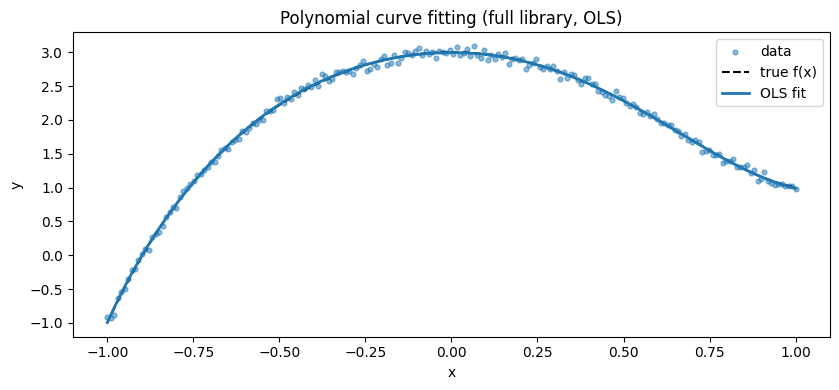

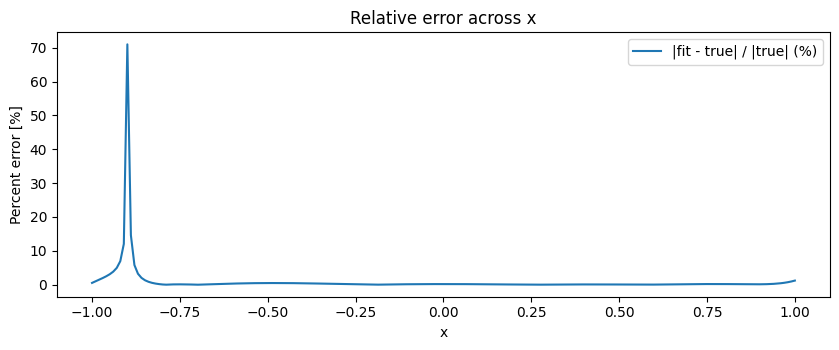

RMSE (fit vs true): 5.6562e-03
MAE  (fit vs true): 4.2598e-03
Max % error: 70.98%,   Median % error: 0.15%


In [27]:
# Figure 1 - Data, true curve, OLS fit 

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_hat, label="OLS fit", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Polynomial curve fitting (full library, OLS)")
plt.legend()
plt.tight_layout()
plt.show()

# Figure 2 - Pectent error

eps = 1e-8
denom = np.maximum(np.abs(y_true), eps)  # robust normalization
err_pct = 100.0 * np.abs(y_hat - y_true) / denom

plt.figure(figsize=(8.5, 3.6))
plt.plot(x, err_pct, label="|fit - true| / |true| (%)")
plt.xlabel("x"); plt.ylabel("Percent error [%]")
plt.title("Relative error across x")
plt.legend()
plt.tight_layout()
plt.show()

# Summary of the Evaluation metric 

rmse = np.sqrt(np.mean((y_hat - y_true)**2))
mae  = np.mean(np.abs(y_hat - y_true))
print(f"RMSE (fit vs true): {rmse:.4e}")
print(f"MAE  (fit vs true): {mae :.4e}")
print(f"Max % error: {err_pct.max():.2f}%,   Median % error: {np.median(err_pct):.2f}%")
